In [1]:
from utils.audio_dataset_utils import train_val_dataset
from network_models.soundsream_models_and_utils.ss_model_dim_red import SSDimRedModel
from network_models.soundsream_models_and_utils.ss_model_conv import SSConvModel3Sec, SmallConvModel
from network_models.soundsream_models_and_utils.ss_encoded_dataset import ss_encoded_dataset_full
import torch
from torch.utils.data import DataLoader
from network_models.soundsream_models_and_utils.ss_complex_conv_net import SSComplexConvModel3Sec

batch_size = 6

#data_set= ss_encoded_dataset_full(
#    csvPath="/home/ckwdani/Programming/Projects/masterarbeit/Jupyter/mainProject/notebooks/content/data/allEncs_betterSS_12_1_relwrap_music.pkl", device="cuda")
#data_set= ss_encoded_dataset_full(csvPath="/home/ckwdani/Programming/Projects/masterarbeit/Jupyter/mainProject/notebooks_clip/content/datasets/mfcc/mfcc_dataset_3_5_sec_induced.pkl", device="cuda")
data_set= ss_encoded_dataset_full(csvPath="/home/ckwdani/Programming/Projects/masterarbeit/Jupyter/mainProject/notebooks_clip/content/datasets/soundstream_encoded/allEncodings_noInducednoStimuli_3_5_sec_v12_1_basic.pkl", device="cuda")




modelDimRed = SSDimRedModel(eval_mode= True).cuda()
modelConv = SSConvModel3Sec(xSize=512, ySize=175, eval_mode= True).cuda()
#modelComplexConv = SSComplexConvModel3Sec(eval_mode=True).to("cuda")
#smalConfModel = SmallConvModel(xSize=110, ySize=40).cuda()

# trainDS, testDs = train_val_dataset(data_set, val_split=0.1, seed=100)
# trainDS, valDs = train_val_dataset(trainDS, val_split=0.1, seed=100)
trainDS, testDs = train_val_dataset(data_set, val_split=0.2, seed=100)
valDs, testDs = train_val_dataset(testDs, val_split=0.5, seed=100)

2023-03-25 15:35:51.335641: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-25 15:35:52.018223: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-03-25 15:35:52.018281: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory
2023-03-25 15:35:52.018286: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libraries. If you would like to use Nv

In [2]:
import gc

gc.collect()

#modelConv.load_state_dict(torch.load("../content/soundstream/experiments/experiment_v_12_1_NR3_relu/Run_Nr_0/conv/emo_reco_best_ep852_acc_75.pth"))
#modelDimRed.load_state_dict(torch.load("../content/soundstream/experiments/experiment_v_12_1_NR3_relu/Run_Nr_0/dimred/emo_reco_best_ep824_acc_70.pth"))
#modelDimRed.load_state_dict(torch.load("/home/ckwdani/Programming/Projects/masterarbeit/Jupyter/mainProject/notebooks/content/soundstream/experiments/dim_red/Nr1_tess/emo_reco_best_ep105_acc_96.pth"))
modelConv.load_state_dict(torch.load("/home/ckwdani/Programming/Projects/masterarbeit/Jupyter/mainProject/notebooks/content/soundstream/experiments_final/Run_Nr_0/conv/emo_reco_best_ep149_acc_73.pth"))
modelDimRed.load_state_dict(torch.load("/home/ckwdani/Programming/Projects/masterarbeit/Jupyter/mainProject/notebooks/content/soundstream/experiments_final/Run_Nr_0/dimred/emo_reco_best_ep563_acc_69.pth"))
#modelComplexConv.load_state_dict(torch.load("/home/ckwdani/Programming/Projects/masterarbeit/Jupyter/mainProject/notebooks/content/soundstream/experiments/conv_complex/Nr2_tess/emo_reco_best_ep92_acc_100.pth"))
#modelComplexConv.load_state_dict(torch.load("/home/ckwdani/Programming/Projects/masterarbeit/Jupyter/mainProject/notebooks/content/soundstream/experiments/conv_complex/Nr4/emo_reco_best_ep95_acc_69.pth"))
#modelComplexConv.load_state_dict(torch.load("/home/ckwdani/Programming/Projects/masterarbeit/Jupyter/mainProject/notebooks/content/soundstream/experiments/conv_complex/Nr2_tess/emo_reco_best_ep92_acc_100.pth"))


<All keys matched successfully>

In [3]:
modelConv.parameters

<bound method Module.parameters of SSConvModel3Sec(
  (base_linear1): Linear(in_features=300, out_features=100, bias=True)
  (base_linear2): Linear(in_features=100, out_features=4, bias=True)
  (base_linear3): Linear(in_features=4, out_features=4, bias=True)
  (base_linear4): Linear(in_features=4, out_features=7, bias=True)
  (dropouts): Dropout(p=0, inplace=False)
  (conv1): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (linear1): Linear(in_features=80000, out_features=300, bias=True)
  (linear2): Linear(in_features=300, out_features=300, bias=True)
)>

In [3]:
from utils.utils__evalutation import evaluate
import gc


def evaluateLoc(device, model, dataset):

    return evaluate(device, model, dataset, batch_size)

0 of 609
60 of 609
120 of 609
180 of 609
240 of 609
300 of 609
360 of 609
420 of 609
480 of 609
540 of 609
600 of 609
------------------ Conv: ----------------
           accuracy  precision  recall   support
   angry     0.683     0.612     0.813    91
 disgust     0.683     0.649     0.667    108
    fear     0.683     0.667     0.595    74
   happy     0.683     0.716     0.578    83
 neutral     0.683     0.747     0.730    89
     sad     0.683     0.740     0.676    105
surprise     0.683     0.689     0.712    59
                                          609

 
     avg     0.683     0.688     0.682    

                   angry     disgust        fear       happy     neutral         sad    surprise    support
       angry       0.813       0.022       0.077       0.022       0.055       0.011       0.000         91
     disgust       0.157       0.667       0.046       0.065       0.019       0.019       0.028        108
        fear       0.108       0.068       0.595       0.

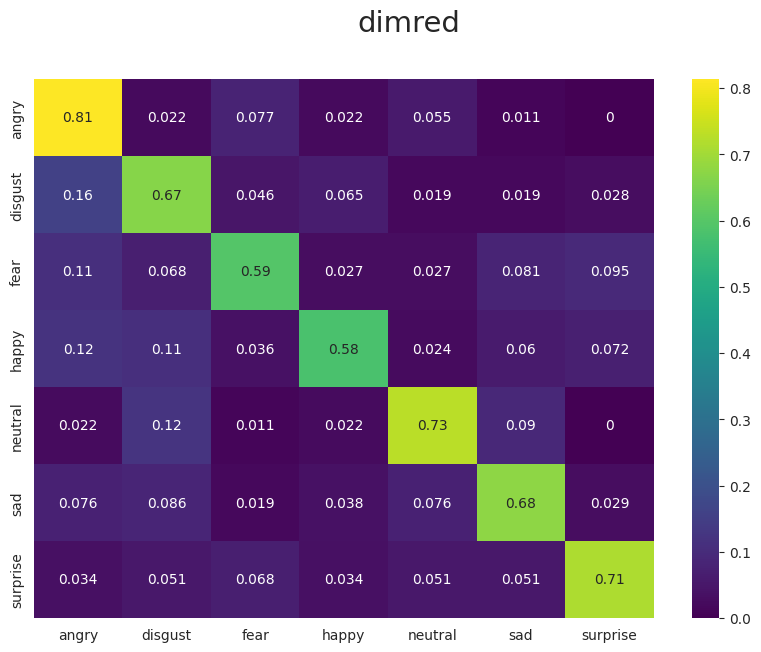

In [5]:
from utils.eval_utils import classificationReport, confusion_matrix, confustion_matrix_heatmap

trueConv, predsConv = evaluateLoc("cuda", modelConv, valDs)
print("------------------ Conv: ----------------")
classificationReport(trueConv, predsConv, data_set.encoded_dataset.label_list)
confusion_matrix(trueConv, predsConv, data_set.encoded_dataset.label_list)
confustion_matrix_heatmap(trueConv, predsConv, data_set.encoded_dataset.label_list, "dimred")


print()

In [14]:
from utils.eval_utils import classificationReport, confusion_matrix

trueConv, predsConv = evaluateLoc("cuda", modelConv, testDs)
trueDimRed, predsDimRed = evaluateLoc("cuda", modelDimRed, testDs)

print("------------------ Conv: ----------------")
classificationReport(trueConv, predsConv, data_set.encoded_dataset.label_list)
confusion_matrix(trueConv, predsConv, data_set.encoded_dataset.label_list)
print("------------------ DimRed: ----------------")
classificationReport(trueDimRed, predsDimRed, data_set.encoded_dataset.label_list)
confusion_matrix(trueDimRed, predsDimRed, data_set.encoded_dataset.label_list)


print("")

0 of 610
60 of 610
120 of 610
180 of 610
240 of 610
300 of 610
360 of 610
420 of 610
480 of 610
540 of 610
600 of 610
0 of 610
60 of 610
120 of 610
180 of 610
240 of 610
300 of 610
360 of 610
420 of 610
480 of 610
540 of 610
600 of 610
------------------ Conv: ----------------
           accuracy  precision  recall   support
   angry     0.746     0.705     0.798    99
 disgust     0.746     0.826     0.710    107
    fear     0.746     0.756     0.775    80
   happy     0.746     0.611     0.714    77
 neutral     0.746     0.787     0.779    95
     sad     0.746     0.833     0.714    91
surprise     0.746     0.710     0.721    61
                                          610

 
     avg     0.746     0.747     0.745    

                   angry     disgust        fear       happy     neutral         sad    surprise    support
       angry       0.798       0.040       0.030       0.061       0.020       0.010       0.040         99
     disgust       0.112       0.710       0.009